# Projekt - odovzdanie 3

**Autori:** Patrik Villant, Ivan Vykopal
 
**Cvičenie:** Utorok o 14:00
 
**Cvičiaci:** Ing. Peter Bakonyi
 
**Dátová sada:** 55
 
**Podiel práce:** 50/50

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
import datetime
import math
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [2]:
class MergeTransformer(TransformerMixin):
    def __init__(self, personal, other, columns=['name', 'address']):
        self.personal = personal
        self.other = other
        self.columns = columns
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data = pd.merge(self.personal, self.other, on=self.columns, how = 'inner')
        return data

In [3]:
class SplittingMedicalTransformer(TransformerMixin):
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        for i in range(len(data)):
            row = data.medical_info[i]
            if str(row) == 'nan':
                j ={'mean_glucose': np.nan,
                     'std_glucose': np.nan,
                     'kurtosis_glucose': np.nan,
                     'skewness_glucose': np.nan,
                     'mean_oxygen': np.nan,
                     'std_oxygen': np.nan,
                     'kurtosis_oxygen': np.nan,
                     'skewness_oxygen': np.nan}
            else:
                j = eval(str(row))
            data.at[i,'mean_glucose'] = float(j['mean_glucose'])
            data.at[i,'std_glucose'] = float(j['std_glucose'])
            data.at[i,'kurtosis_glucose'] = float(j['kurtosis_glucose'])
            data.at[i,'skewness_glucose'] = float(j['skewness_glucose'])
            data.at[i,'mean_oxygen'] = float(j['mean_oxygen'])
            data.at[i,'std_oxygen'] = float(j['std_oxygen'])
            data.at[i,'kurtosis_oxygen'] = float(j['kurtosis_oxygen'])
            data.at[i,'skewness_oxygen'] = float(j['skewness_oxygen'])
        data = data.drop(columns=['medical_info'])
        return data

In [4]:
class DeduplicationTransformer(TransformerMixin):
    def __init__(self, columns=['name', 'address']):
        self.columns = columns
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        duplicates = data[data.duplicated(self.columns)]
        unique_names = duplicates.name.unique()
        for i in unique_names: 
            helper = data[data.name == i]
            helper = helper.fillna(method='ffill')
            helper = helper.drop_duplicates(self.columns, keep = 'last')
            data = data.append(helper)
    
        data.drop_duplicates(self.columns, inplace = True, keep = 'last')
        data = data.reset_index(drop = True)
        return data

In [5]:
class StripTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data[self.columns] = data[self.columns].apply(lambda x: x.str.strip())
        return data

In [6]:
class UnificationToNanTransformer(TransformerMixin):
    
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data.replace(to_replace=r'\?+', value=np.nan, regex=True, inplace=True)
        return data

In [7]:
class DateUnificationTransformer(TransformerMixin):
    
    def _unifyFormats(self, data):
        data = data[:10]
        date = re.sub('[0-9]','0', data)
        if date == '0000/00/00':
            data = data.replace('/', '-')
        if date == '00/00/0000':
            data = data[6:] + '-' + data[3:5] +'-' + data[:2]
        if date == '00-00-00':
            if data[0] == 0 or data[0] == 1:
                data = '20' + data[:2] + '-' + data[3:5] + '-' + data[6:]
            else:
                data = '19' + data[:2] + '-' + data[3:5] + '-' + data[6:]
        
        return data
    
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data['date_of_birth'] = data['date_of_birth'].apply(self._unifyFormats)
        return data

In [8]:
class AddressUnificationTransformer(TransformerMixin):
    
    def _splittAddress(self, data):
        data['street'] = 'street'
        data['town'] = 'town'
        data['psc'] = 'psc'
        for i in range(len(data.address)):
            helper = re.split('\n|, ', data.address[i])
            data.loc[i, 'street'] = str(helper[0]).strip()
            data.loc[i, 'town'] = str(helper[1])
            if len(helper) == 2:
                data.loc[i, 'town'] = str(helper[1][:-8])
                data.loc[i, 'psc'] = str(helper[1][-8:])
            if len(helper) == 3:
                data.loc[i, 'psc'] = str(helper[2])
        data = data.drop(columns=['address'])
        return data
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data = self._splittAddress(data)
        return data

In [9]:
class AgeUnificationTransformer(TransformerMixin):
    
    def _unifyAge(self, data):
        date = datetime.date(2019, 12, 31)
        birth = datetime.date(int(data[:4]), int(data[5:7]), int(data[8:]))
        age = date - birth
        age = age.days // 365
        return age
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data['age'] = data['date_of_birth'].apply(self._unifyAge)
        return data

In [10]:
class PregnantUnificationTransformer(TransformerMixin):
          
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        for i in range(len(data)):
            if data.loc[i, 'pregnant'] in ['f','F','FALSE']:
                data.loc[i, 'pregnant'] = int(0)
            elif data.loc[i, 'pregnant'] in ['t','T','TRUE']:
                data.loc[i, 'pregnant'] = int(1)
            elif data.loc[i, 'sex'] == 'Male':
                data.loc[i, 'pregnant'] = int(0)
            else: 
                data.loc[i, 'pregnant'] = np.nan
        data.pregnant = data.pregnant.astype('int64')
        return data

In [11]:
class WorkclassUnificationTransformer(TransformerMixin):
    def _unifyWorkclass(self, data):
        string = str(data).lower()
        if string == 'nan':
            return np.nan
        else:
            return string
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data.workclass = data.workclass.apply(self._unifyWorkclass)
        return data

In [12]:
class RelationshipUnificationTransformer(TransformerMixin):
    def _unifyRelationship(self, data):
        string = str(data)
        if string == 'nan':
            return np.nan
        else:
            return string.replace('_', '-')
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        data['relationship'] = data['relationship'].apply(self._unifyRelationship)
        return data

In [13]:
class MedianTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.medians = {}
        
    def fit(self, data, y=None):
        for column in self.columns:
            self.medians[column] = data[column].median()
        return self
    
    def transform(self, data, y=None):
        for column in self.columns:
            data[column].fillna(self.medians[column], inplace=True)
            
        return data

In [14]:
class MeanTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.means = {}
        
    def fit(self, data, y=None):      
        for column in self.columns:
            self.means[column] = data[column].mean()
        return self
    
    def transform(self, data, y=None):
        for column in self.columns:
            data[column].fillna(self.means[column], inplace=True)
            
        return data

In [15]:
class MostFrequentTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.modes = {}
        
    def fit(self, data, y=None):
        for column in self.columns:
            self.modes[column] = data[column].mode()[0]
        return self
    
    def transform(self, data, y=None):
        for column in self.columns:
            data[column].fillna(self.modes[column], inplace=True)
            
        return data

In [16]:
class KNNTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def _kNN(self, data, column):
        imp_kNN = KNNImputer(missing_values=np.nan)
        data[column] = imp_kNN.fit_transform(data[[column]])
        return data
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        for column in self.columns:
            data = self._kNN(data, column)
            
        return data

In [17]:
class AgeToNanTransformer(TransformerMixin):
        
    def _ageToNan(self, data):
        if data < 0:
            return np.nan
        else:
            return data
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None): 
        data['age'] = data['age'].apply(self._ageToNan)   
        return data

Zmena...

In [18]:
class ClassRemovalTransformer(TransformerMixin):
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None): 
        data = data[data['class'].notna()]
        data = data.reset_index(drop = True)
        return data


In [19]:
class OutliersTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def _standarddeviation(self, data):
        data_mean, data_std = np.mean(data), np.std(data)

        cut_off = data_std * 3
        lower, upper = data_mean - cut_off, data_mean + cut_off 

        outliers = [x for x in data if x < lower or x > upper] 
        print('Počet záznamov=', len(data), ', počet outlierov: %d' % len(outliers))
        print('\n')
                
    def _setOutliers(self, data, column):
        percentile_95 = data[column].quantile(0.95)
        percentile_05 = data[column].quantile(0.05)
        data.loc[data[column] < percentile_05, column] = percentile_05
        data.loc[data[column] > percentile_95, column] = percentile_95
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        for column in self.columns:
            print('Atribút ', column, '\n')
            print('Pred úpravou:')
            self._standarddeviation(data[column])
            self._setOutliers(data, column)
            print('Po úprave:')
            self._standarddeviation(data[column])
            print('-------------------------------------------------------------------------------------------------------------')

            
        return data

In [20]:
class PowerTransformTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def _powerTransform(self, data, column):
        power = PowerTransformer(method='yeo-johnson', standardize=True) 
        data[column] = power.fit_transform(data[[column]])
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        for column in self.columns:
            self._powerTransform(data, column)
            
        return data

In [21]:
class HoursUnificationTransformer(TransformerMixin):
        
    def _hoursToNan(self, data):
        if data < 0 or data > 168:
            return np.nan
        else:
            return data
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None): 
        data['hours-per-week'] = data['hours-per-week'].apply(self._hoursToNan)   
        return data

Popísať vykonané zmeny

In [22]:
class LabelEncoderTransformer(TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
        self.encoders = {}
        for column in self.columns:
            self.encoders[column] = LabelEncoder()
        
    def fit(self, data, y=None):
        for column in self.columns:
            self.encoders[column].fit(list(data[column]) + ['Unknown'])
        return self
    
    def transform(self, data, y=None): 
        for column in self.columns:
            data_list = list(data[column])
            for unique_item in np.unique(data[column]):
                if unique_item not in self.encoders[column].classes_:
                    data_list = ['Unknown' if x==unique_item else x for x in data_list]

            data[column] = self.encoders[column].transform(data_list)
        return data

In [23]:
personal_train = pd.read_csv('personal_train.csv', index_col='Unnamed: 0')

In [24]:
other_train = pd.read_csv('other_train.csv', index_col='Unnamed: 0')

In [25]:
personal_valid = pd.read_csv('personal_valid.csv', index_col='Unnamed: 0')

In [26]:
other_valid = pd.read_csv('other_valid.csv', index_col='Unnamed: 0')

In [27]:
merge = Pipeline([('merge', MergeTransformer(personal_train, other_train, ['name', 'address']))])

data_train = pd.DataFrame()
data_train = merge.transform(data_train)

In [28]:
most_frequent_missing = ['race', 'marital-status', 'occupation', 'relationship', 'native-country', 'workclass', 'capital-gain', 'capital-loss']

glucose = ['mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose']

oxygen_age = ['mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen', 'age']

encode = ['sex', 'race', 'marital-status', 'occupation', 'relationship', 'income', 'native-country', 'workclass', 'town', 'psc', 'street']

outliers = ['fnlwgt', 'mean_glucose', 'std_glucose', 'kurtosis_glucose', 'skewness_glucose', 'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen', 'skewness_oxygen']

pip = Pipeline([('split_medical', SplittingMedicalTransformer()),
               ('deduplication', DeduplicationTransformer(['name','address'])),
               ('strip', StripTransformer(['sex', 'race', 'marital-status', 'occupation', 'relationship', 'education', 'income', 'native-country', 'workclass'])),
               ('nan_unification', UnificationToNanTransformer()),
               ('date_unification', DateUnificationTransformer()),
               ('address_unification', AddressUnificationTransformer()),
               ('age_unification', AgeUnificationTransformer()),
               ('pregnant_unification', PregnantUnificationTransformer()),
               ('workclass_unification', WorkclassUnificationTransformer()),
               ('relationship_unification', RelationshipUnificationTransformer()),
               ('age_to_nan', AgeToNanTransformer()),
               ('most_frequent_missing', MostFrequentTransformer(most_frequent_missing)),
               ('class_remove', ClassRemovalTransformer()),
               ('hours-per-week', MeanTransformer(['hours-per-week'])),
               ('glucose', KNNTransformer(glucose)),
               ('oxygen_age', MedianTransformer(oxygen_age)),
               ('power_transform',PowerTransformTransformer(outliers)),
               ('outliers', OutliersTransformer(outliers)),
               ('encode', LabelEncoderTransformer(encode))])

pip.fit(data_train)
data_train = pip.transform(data_train)

Atribút  fnlwgt 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 22


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  mean_glucose 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 3


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  std_glucose 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 17


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  kurtosis_glucose 

Pred úpravou:
Počet záznamov= 3932 , počet outlierov: 18


Po úprave:
Počet záznamov= 3932 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  ske

In [29]:
merge = Pipeline([('merge', MergeTransformer(personal_valid, other_valid, ['name', 'address']))])

data_valid = pd.DataFrame()
data_valid = merge.transform(data_valid)

In [30]:
data_valid = pip.transform(data_valid)

Atribút  fnlwgt 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 2


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  mean_glucose 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 0


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  std_glucose 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 5


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  kurtosis_glucose 

Pred úpravou:
Počet záznamov= 1311 , počet outlierov: 5


Po úprave:
Počet záznamov= 1311 , počet outlierov: 0


-------------------------------------------------------------------------------------------------------------
Atribút  skewne

In [31]:
data_valid.head()

,name,age,sex,date_of_birth,race,marital-status,occupation,pregnant,education-num,relationship,...,std_glucose,kurtosis_glucose,skewness_glucose,mean_oxygen,std_oxygen,kurtosis_oxygen,skewness_oxygen,street,town,psc
0,Philip Miller,52,1,1967-09-03,5,4,4,0,9.0,1,...,-0.010168,-1.083175,-0.255202,-0.416802,-0.491678,0.332974,0.387414,3922,2226,3520
1,Mitch Wilson,50,0,1969-07-19,5,4,0,0,10.0,3,...,1.065302,-0.959011,-1.406078,0.422036,0.471178,-0.495901,-0.527878,3922,2933,3520
2,James Olsen,36,1,1983-01-20,5,2,13,0,9.0,0,...,-0.281893,-0.503283,-0.059564,-1.386288,-1.454295,1.468397,1.458314,3922,2933,3520
3,Maurice Riley,56,1,1963-04-18,5,2,11,0,4.0,0,...,-0.010168,-0.971483,-0.600971,-0.241584,-0.059667,0.314069,0.286062,3922,810,3520
4,Larry Stanley,72,1,1947-09-04,5,4,9,0,10.0,3,...,-1.670691,1.733144,1.706862,1.609443,1.272269,-1.452033,-1.462614,3922,2933,3520


## Manuálne vytvorenie rozhodovaích pravidiel

### Pre jeden atribút

Zvolený atribút **kurtosis_glucose**

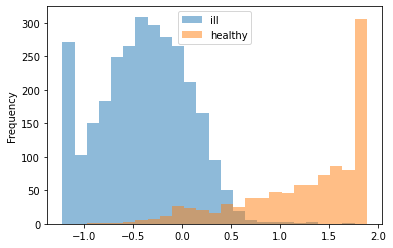

In [32]:
ill_kg = data_train[data_train['class'] == 0.0].kurtosis_glucose
healthy_kg = data_train[data_train['class'] == 1.0].kurtosis_glucose
df = pd.DataFrame({
    'ill': ill_kg,
    'healthy': healthy_kg})
ax = df.plot.hist(bins=25, alpha=0.5)

Na základe hostogamu sme si zvolili hodnotu 0.5. Tí čo budú pod touto hodnotou budú považovaný za chorých, ostatní budú považovaní za zdravých.

In [33]:
class KurtosisGlucosePredictor():
    
    def predict(self, data):
        if data <= 0.5:
            return 0.0
        else:
            return 1.0
    
    def transform(self, data):
        predicted = data['kurtosis_glucose'].apply(self.predict)
        return predicted

In [34]:
predicted_train = KurtosisGlucosePredictor().transform(data_train)

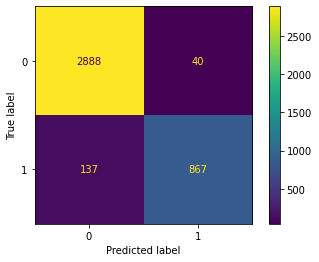

In [35]:
cm = confusion_matrix(data_train['class'], predicted_train)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

In [36]:
print(classification_report(data_train['class'], predicted_train))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      2928
         1.0       0.96      0.86      0.91      1004

    accuracy                           0.95      3932
   macro avg       0.96      0.92      0.94      3932
weighted avg       0.96      0.95      0.95      3932



In [37]:
print(accuracy_score(data_train['class'], predicted_train))

0.9549847405900305


In [38]:
predicted_valid = KurtosisGlucosePredictor().transform(data_valid)

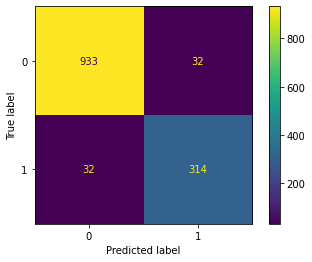

In [39]:
cm = confusion_matrix(data_valid['class'], predicted_valid)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

In [40]:
print(classification_report(data_valid['class'], predicted_valid))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       965
         1.0       0.91      0.91      0.91       346

    accuracy                           0.95      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



In [42]:
print(accuracy_score(data_valid['class'], predicted_valid))

0.9511823035850496


### Pre tri atribúty

Zvolený atribút **kurtosis_glucose**, **mean_glucose**, **mean_oxygen**.

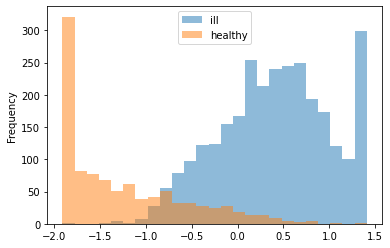

In [43]:
ill_mg = data_train[data_train['class'] == 0.0].mean_glucose
healthy_mg = data_train[data_train['class'] == 1.0].mean_glucose
df = pd.DataFrame({
    'ill': ill_mg,
    'healthy': healthy_mg})
ax = df.plot.hist(bins=25, alpha=0.5)

Vybrali sme hodnotu: -0.7

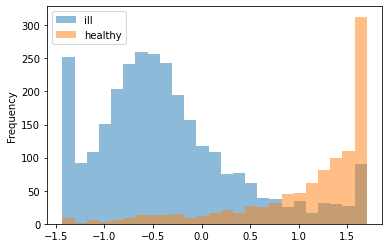

In [44]:
ill_mo = data_train[data_train['class'] == 0.0].mean_oxygen
healthy_mo = data_train[data_train['class'] == 1.0].mean_oxygen
df = pd.DataFrame({
    'ill': ill_mo,
    'healthy': healthy_mo})
ax = df.plot.hist(bins=25, alpha=0.5)

Vybrali sme hodnotu: 0.7

In [63]:
class ComplexPredictor():
    
    def predict(self, row):
        if row.kurtosis_glucose <= 0.5:
            #chorý
            if row.mean_glucose >= -0.7:
                #chorý
                if row.mean_oxygen <= 0.7:
                    return 0.0
                else:
                    return 0.0 
            else:
                if row.mean_oxygen <= 0.7:
                    return 0.0
                else:
                    return 1.0 
        else:
            #zdravý
            if row.mean_glucose >= -0.7:
                #chorý
                if row.mean_oxygen <= 0.7:
                    return 0.0
                else:
                    return 1.0 
            else:
                if row.mean_oxygen <= 0.7:
                    return 1.0
                else:
                    return 1.0 
        
    
    def transform(self, data):
        predicted = []
        for i in range(len(data)):
            predicted.append(self.predict(data.loc[i]))
            
        return pd.Series(predicted)

In [64]:
predicted_train = ComplexPredictor().transform(data_train)

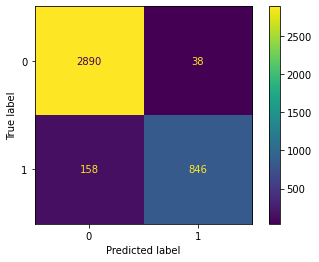

In [65]:
cm = confusion_matrix(data_train['class'], predicted_train)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

In [66]:
print(classification_report(data_train['class'], predicted_train))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      2928
         1.0       0.96      0.84      0.90      1004

    accuracy                           0.95      3932
   macro avg       0.95      0.91      0.93      3932
weighted avg       0.95      0.95      0.95      3932



In [67]:
print(accuracy_score(data_train['class'], predicted_train))

0.9501525940996948


In [68]:
predicted_valid = ComplexPredictor().transform(data_valid)

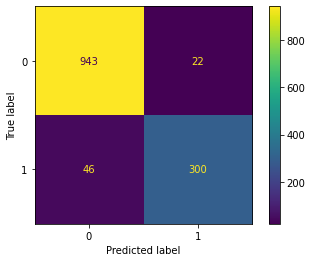

In [69]:
cm = confusion_matrix(data_valid['class'], predicted_valid)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot()

In [70]:
print(classification_report(data_valid['class'], predicted_valid))

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97       965
         1.0       0.93      0.87      0.90       346

    accuracy                           0.95      1311
   macro avg       0.94      0.92      0.93      1311
weighted avg       0.95      0.95      0.95      1311



In [71]:
print(accuracy_score(data_valid['class'], predicted_valid))

0.9481311975591151
